<a href="https://colab.research.google.com/github/LiFeLeSS5858/Quantum-teleporting/blob/main/PR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задача**

Реализовать схему квантовой телепортации, проверить программу для различных 
состояний, которые нужно передать.

**Решение:**

Для решения данной задачи необходимо реализовать схему, изображенную ниже: 

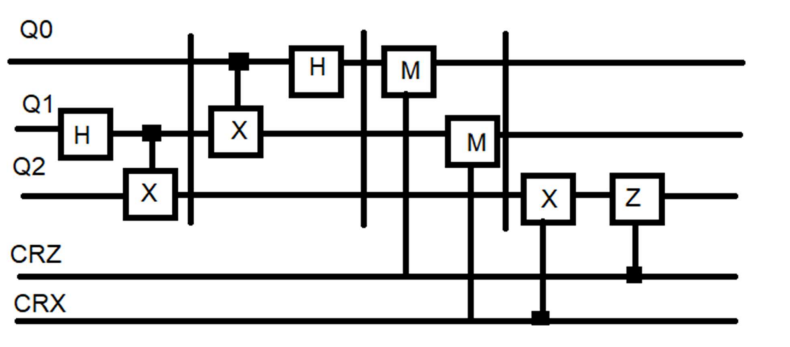

Где:

Q0 – кубит Алисы, который она хочет передать.

Q1 и Q2 – кубиты, запутанные третьей стороной, и кубит Q1 отдается Алисе, а кубит Q2 – 
Бобу. 

CRZ и CRX – это классические биты, в которые будут записываться состояния полученные 
при измерении кубитов Алисы, биты затем передаются Бобу, и в зависимости от 
полученных битов, Боб будет применять необходимые гейты, чтобы получить состояние 
кубита Алисы:

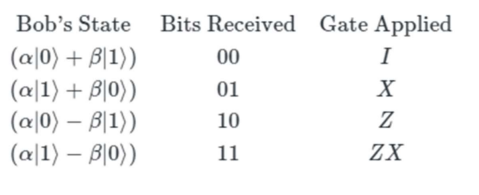

Общий алгоритм квантовой телепортации таков: 
1. Третья сторона запутывает два кубита, один отдает Алисе, а другой Бобу.

2. Алиса применяет на свои два кубита (Первый кубит который передается, и 
на тот, что она получила от третьей стороны) обратную цепь Белла. 

3. Алиса измеряет свои кубиты, а полученные два бита передает по 
классическим каналам связи. 

4. Получив биты, Боб, в зависимости от их значения применяет на свой кубит 
гейты и получает кубит с состоянием кубита Алисы Q1, при этом состояние 
кубитов Алисы схлопывается и, таким образом, происходит телепортация, 
Боб имеет первоначальный кубит, а Алиса уже нет. 

**Программная реализация:**

Импортируем библиотеки: 


In [18]:
#pip install qiskit

In [2]:
# Импортируем библиотеки
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector


Функция для создания пары Белла:

In [3]:
def bell_circuit(qc, a, b): # схема, использующаяся для создания кубитов в состоянии Белла
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
    return qc

Функция схемы Алисы: 


In [4]:
def alice_circuit(qc, psi, a): # Гейты, которыми Алиса влияет на свои кубиты
    qc.cx(psi, a)
    qc.h(psi)
    return qc

Функция измерения кубитов: 

In [5]:
def measure_circuit(qc, a, b):  # Измеряем кубиты и отправляем результаты Бобу
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
    return qc

Функция схемы Боба: 

In [6]:
# Боб получает классические биты, и в зависимости от их значения, влияет на свой кубит, в результате он получит "Телепортированный" кубит Алисы
def bob_circuit(qc, qubit, crz, crx):
    # Мы используем c_if для того, чтобы применять гейты x и z к кубитам в зависимости от значения битов crx и crz 
    qc.x(qubit).c_if(crx, 1) 
    qc.z(qubit).c_if(crz, 1) 
    return qc

In [7]:
# Готовая схема квантовой телепортации
qr = QuantumRegister(3, name="q")    
crz = ClassicalRegister(1, name="crz") 
crx = ClassicalRegister(1, name="crx") 
teleportation_circuit = QuantumCircuit(qr, crz, crx)

# Создаем пару кубитов в состоянии Белла, один кубит отдаем Алисе, а другой Бобу
teleportation_circuit = bell_circuit(teleportation_circuit, 1, 2)

# Алиса действует на свои кубиты (Один изначальный и один запутанный), используя обратную схему Белла
teleportation_circuit.barrier() 
teleportation_circuit = alice_circuit(teleportation_circuit, 0, 1)

# После чего, Алиса измеряет кубиты и отправляет значения в виде классических кубитов по любому каналу связи
teleportation_circuit = measure_circuit(teleportation_circuit, 0, 1)

# Узнав классические биты, Боб наверняка знает, как ему надо подействовать на свой кубит, чтобы получить изначальный кубит Алисы
teleportation_circuit.barrier()
teleportation_circuit = bob_circuit(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ 0x1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ 0x1 ╞═══════
                                     0    └─────┘

Проверим работу схемы на случайных квантовых состояниях. 

Для проверки будем использовать движок симуляций Aer
 
Для начала, приведем код для создания схемы в приличный вид: 

In [8]:
# Переделаем создание схемы в функцию, инициализирующую состояние кубита Алисы по вектору psi
def build_teleport_circuit(psi): # psi - стартовое состояние кубита Алисы 
    init_gate = Initialize(psi) # создаем гейт для инициализации
    init_gate.label = "init"
    # Классическая реализация квантовой телепортации использует 3 кубита и 2 классических бита в разных регистрах
    qr = QuantumRegister(3, name="q")    
    crz = ClassicalRegister(1, name="crz") 
    crx = ClassicalRegister(1, name="crx") 
    teleportation_circuit = QuantumCircuit(qr, crz, crx)

    teleportation_circuit.append(init_gate, [0]) # Инициализируем кубит Алисы
    teleportation_circuit.barrier()

    # Создаем пару кубитов в состоянии Белла, один кубит отдаем Алисе, а другой Бобу
    teleportation_circuit = bell_circuit(teleportation_circuit, 1, 2)

    # Алиса действует на свои кубиты (Один изначальный и один запутанный), используя обратную схему Белла
    teleportation_circuit.barrier() 
    teleportation_circuit = alice_circuit(teleportation_circuit, 0, 1)

    # После чего, Алиса измеряет кубиты и отправляет значения в виде классических кубитов по любому каналу связи
    teleportation_circuit = measure_circuit(teleportation_circuit, 0, 1)

    # Узнав классические биты, Боб наверняка знает, как ему надо подействовать на свой кубит, чтобы получить изначальный кубит Алисы
    teleportation_circuit.barrier()
    teleportation_circuit = bob_circuit(teleportation_circuit, 2, crz, crx)
    return teleportation_circuit

Создаем случайный вектор состояния: 

<IPython.core.display.Latex object>

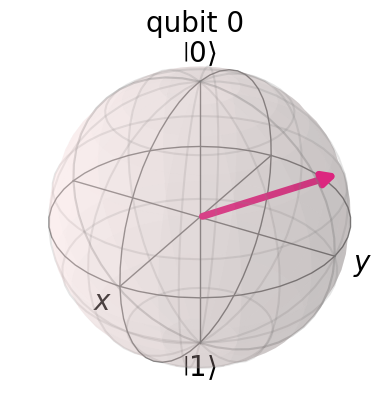

In [9]:
# Для проверки работоспособности схемы, создаем случайный вектор состояния кубита
psi = random_statevector(2)
# Отображаем его через латекс
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# А также сферу Блоха
plot_bloch_multivector(psi)

Собираем схему, и изобразим ее:

In [10]:
test_circuit = build_teleport_circuit(psi)
test_circuit.draw()

┌───────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(0.80323-0.21747j,-0.086185+0.54781j) ├─░────────────░───■──┤ H ├»
       └───────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ──────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                     ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ──────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                     ░      └───┘ ░           »
crz: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
crx: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ░ ┌─┐    ░               
«  q_0: ─░─┤M├────░───────────────
«        ░ └╥┘┌─┐ ░               
«  q_1: ─░──╫─┤M├─░───────────────
«        ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
«  q_2: ─░──╫──╫──░──┤ X ├──┤ Z ├─
«        ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
«           ║  ║       ║   ┌──╨──┐
«crz: 1/════╩══╬═══════╬═══╡ 0x1 ╞
«           0  ║    ┌──╨──┐└─────┘
«crx: 1/═══════╩════╡ 0x1 ╞═══════
«              0    └─────┘

Проводим симуляцию работы квантового компьютера на схеме: 


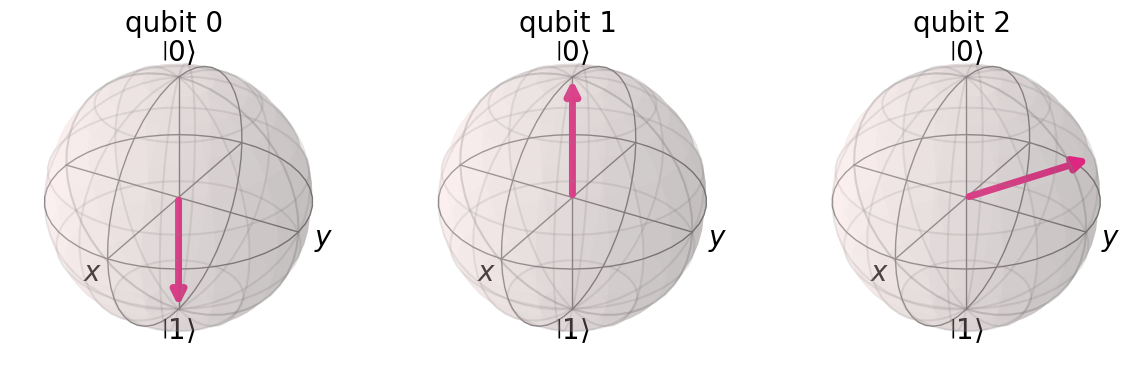

In [11]:
# При помощи симуляции на движке aer, воссоздаем действие схемы и изображаем состояние кубитов в виде сфер Блоха
sim = Aer.get_backend('aer_simulator')
test_circuit.save_statevector() 
out_vector = sim.run(test_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

# Как видим, состояние кубитов Алисы и Боба совпадают, следовательно Телепортация совершается успешно

Проверим работу схемы еще на паре значений: 

<IPython.core.display.Latex object>

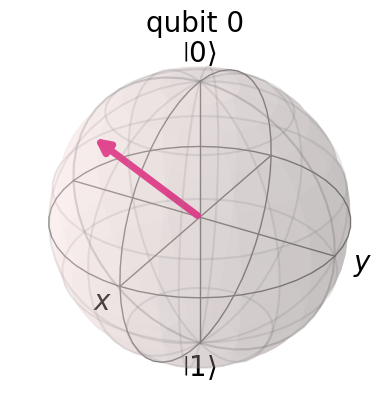

In [12]:
# Для проверки, запустим еще пару симуляций с другими векторами состояния кубита Алисы
psi = random_statevector(2)
# Отображаем его через латекс
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# А также сферу Блоха
plot_bloch_multivector(psi)

In [13]:
test_circuit = build_teleport_circuit(psi)
test_circuit.draw()

┌────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
  q_0: ┤ init(0.35575+0.8514j,0.35623+0.14721j) ├─░────────────░───■──┤ H ├─░─»
       └────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
  q_1: ───────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                  ░ └───┘┌─┴─┐ ░ └───┘      ░ »
  q_2: ───────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                  ░      └───┘ ░            ░ »
crz: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
crx: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
«       ┌─┐    ░               
«  q_0: ┤M├────░───────────────
«       └╥┘┌─┐ ░               
«  q_1: ─╫─┤M├─░───────────────
«        ║ └╥┘ ░  ┌───┐  ┌───┐ 
«  q_2: ─╫──╫──░──┤ X ├──┤ Z ├─
«        ║  ║  ░  └─╥─┘  └─╥─┘ 
«        ║  ║       ║   ┌──╨──┐
«crz: 1/═╩══╬═══════╬═══╡ 0x1 ╞
«        0  ║    ┌──╨──┐└─────┘
«crx: 1/════╩════╡ 0x1 ╞═══════
«           0    └─────┘

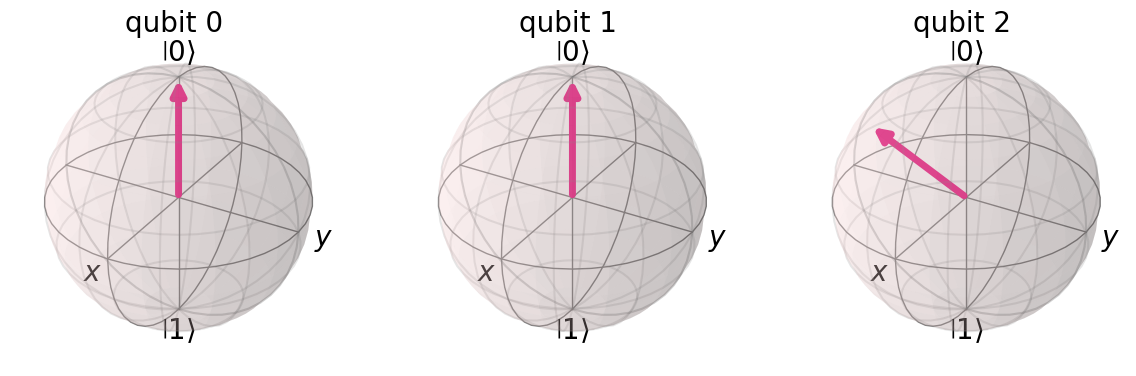

In [14]:
# При помощи симуляции на движке aer, воссоздаем действие схемы и изображаем состояние кубитов в виде сфер Блоха
sim = Aer.get_backend('aer_simulator')
test_circuit.save_statevector() 
out_vector = sim.run(test_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

<IPython.core.display.Latex object>

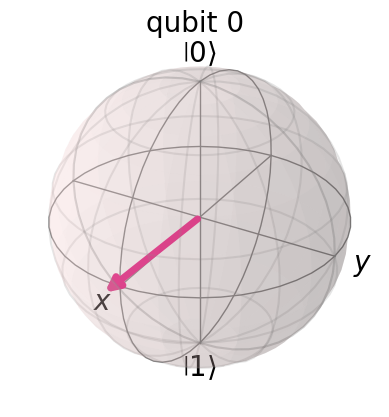

In [15]:
psi = random_statevector(2)
# Отображаем его через латекс
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# А также сферу Блоха
plot_bloch_multivector(psi)

In [16]:
test_circuit = build_teleport_circuit(psi)
test_circuit.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(-0.2421-0.62016j,-0.36842-0.64889j) ├─░────────────░───■──┤ H ├»
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                    ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                    ░      └───┘ ░           »
crz: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
crx: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«        ░ ┌─┐    ░               
«  q_0: ─░─┤M├────░───────────────
«        ░ └╥┘┌─┐ ░               
«  q_1: ─░──╫─┤M├─░───────────────
«        ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
«  q_2: ─░──╫──╫──░──┤ X ├──┤ Z ├─
«        ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
«           ║  ║       ║   ┌──╨──┐
«crz: 1/════╩══╬═══════╬═══╡ 0x1 ╞
«           0  ║    ┌──╨──┐└─────┘
«crx: 1/═══════╩════╡ 0x1 ╞═══════
«              0    └─────┘

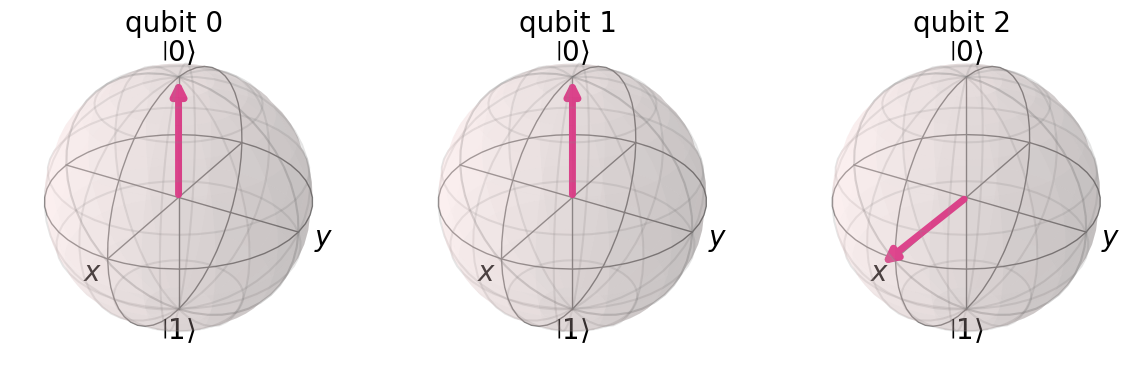

In [17]:
# При помощи симуляции на движке aer, воссоздаем действие схемы и изображаем состояние кубитов в виде сфер Блоха
sim = Aer.get_backend('aer_simulator')
test_circuit.save_statevector() 
out_vector = sim.run(test_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

### Как видим, переданные состояния совпадают с первоначальными состояниями кубита Алисы, отчего можно сказать, что схема квантовой телепортации работает корректно.